# Neural Networks

The goals of this week are to touch the basic concepts related to deep learning and neural networks. Specifically:
- gradient descent
- neural networks
- backpropagation

In this lecture, we will mostly talk about gradient descent.



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

import warnings
warnings.filterwarnings("ignore")


In [2]:
# plotting functions
def plot_loss_contour(Ws, bs, errs):
    plt.contourf(Ws, bs, errs, levels=20)
    plt.colorbar()
    plt.xlabel('w')
    plt.ylabel('b')


In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/intro-stat-learning/ISLP/main/ISLP/data/Credit.csv")

In [4]:
df = df[["Income", "Limit", "Balance"]]
df = df.rename(columns=str.lower)
df = (df - df.mean()) / df.std()
df.shape

(400, 3)

In [5]:
df.sample(5)

,income,limit,balance
259,-0.328050,0.632701,1.244098
336,-0.350777,0.497531,0.883039
4,0.302549,0.069925,-0.411118
291,-0.599555,-0.463825,-0.458969
73,-0.602364,-0.092106,0.176147


This is a regression model that we're used to:

$$
Y = \beta_0 + \beta_1 * X_1 + \beta_2 * X_2
$$

We're now going to fit the same model, but via a different approach. Our notation will also change.

We can write the same model as:
$$ 
Y = W \cdot X + b
$$

where $W$ is a vector that contains the coefficients, $X$ is the feature vector and $b$ is bias. $\cdot$ is the dot product operation:
$$
a \cdot b = \sum_{i=1}^{n} a_i \, b_i
$$




In [6]:
df_sample = df.sample(1)
X = df_sample[["limit"]].values
y = df_sample[["balance"]].values
X, y

(array([[-1.21809263]]), array([[-1.13106027]]))

In [7]:
# regression line
W, b = np.array([[-1.5]]), np.array([1])
z = np.dot(X, W) + b
z

array([[2.82713894]])

The dot product essentially represents a model, however it's not a very good model, because it's weights were instantiated randomly.

How good exactly is this model? In regression we use sum of squares to measure the quality of the fit.

In [8]:
(z - y) ** 2

array([[15.667341]])

Now let's do this for all datapoints.

In [9]:
X = df[["limit"]].values
y = df[["balance"]].values
print(X.shape)
print(y.shape)

(400, 1)
(400, 1)


In [10]:
z = np.dot(X, W) + b
print(z.shape)
z[:10, :]


(400, 1)


array([[ 1.73407887],
       [-0.24083764],
       [-0.5202763 ],
       [-2.09877982],
       [ 0.89511302],
       [-1.15193765],
       [ 1.87574777],
       [-0.54562074],
       [ 1.93293522],
       [-0.35391282]])

In [11]:
def sum_of_squares(z, y):
    return np.sum((z - y)**2)

sum_of_squares(z, y)


np.float64(2728.201628617429)

Sum of squares is our *loss function*.

Putting together what we have so far.


In [12]:
# Initial weights
W, b = np.array([[-1.5]]), np.array([1])

# Model
z = np.dot(X, W) + b

# Loss function
err = sum_of_squares(z, y)
err

np.float64(2728.201628617429)

I can adjust the weights achieve better fit between the model and the data. But how should I adjust the weights to minimize the loss?

Let's try to plot the the value of the loss for a bunch of values of W and b.

In [13]:
Ws = []
bs = []
errs = []

def generate_random_weights(n_weights=1):
    W = np.random.uniform(-2, 2, size=(n_weights, 1))
    b = np.random.uniform(-2, 2)
    return W, b


Text(0, 0.5, 'b')

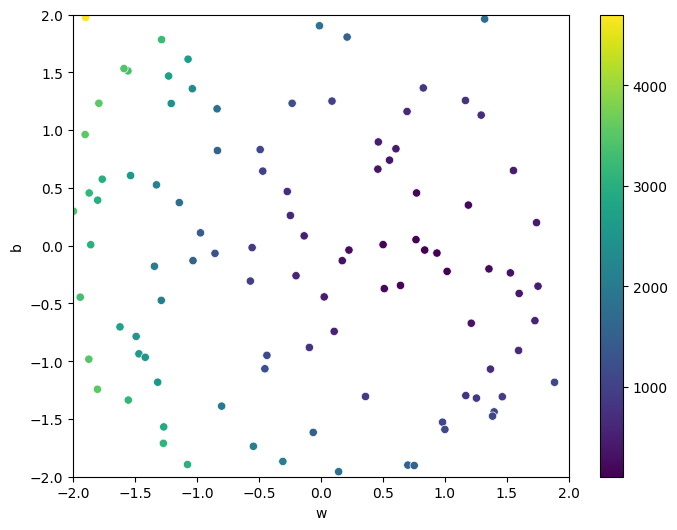

In [14]:
fig, ax = plt.subplots(figsize=(8, 6))

# for i in range(100):
W, b = generate_random_weights()
z = np.dot(X, W) + b
err = sum_of_squares(z, y)
Ws.append(W[0][0])
bs.append(b)
errs.append(err)

ax = sns.scatterplot(x=Ws, y=bs, c=errs, cmap='viridis')
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
plt.colorbar(ax.collections[0])
ax.set_xlabel('w')
ax.set_ylabel('b')


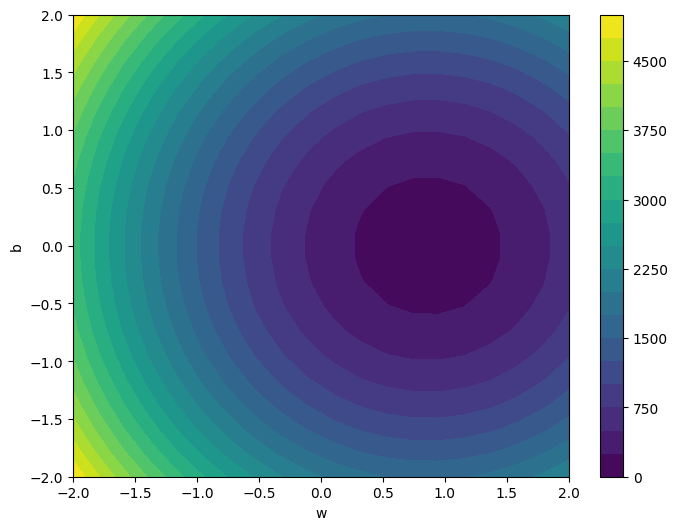

In [15]:
Ws = np.linspace(-2, 2, 20)
bs = np.linspace(-2, 2, 20)
errs = np.zeros((len(bs), len(Ws)))

for i in range(len(bs)):
    for j in range(len(Ws)):
        z = np.dot(X, Ws[j]) + bs[i]
        errs[i,j] = sum_of_squares(z, y)

fig, ax = plt.subplots(figsize=(8, 6))

plot_loss_contour(Ws, bs, errs)


In [16]:
fig = go.Figure(data=[go.Surface(x=Ws, y=bs, z=errs, colorscale='Viridis')])

fig.update_layout(
    title='Error Surface',
    scene=dict(
        xaxis_title='w',
        yaxis_title='b',
        zaxis_title='Error'
    )
)

fig.show()


So, the loss function (that we plotted above) in regression problems is residual sum of squares:

$$
L(W, b) = \sum_{i=1}^{N} \left( y_i - \left( X_i \cdot W + b \right) \right)^2
$$

where $ X_i $ is the feature vector, $ W $ is the weight vector and $ b $ is bias. Keep in mind that we're summing over all datapoints, and so the index i represents a single sample.

So now we need to answer the question - which combination of weights $ W $ and bias $ b $ gives the lowest loss $ L $. In other words, it's an optimization problem and for that we turn to calculus.

We need formulas that allow us to calculate the gradient at any value of the inputs ($W$ and $b$) the direction of maximum decrese in L. Partial derivates give us exactly those formulas.

$$
\frac{\partial L}{\partial W} = -2 \sum_{i=1}^{N} X_i \left( y_i - \left(X_i \cdot W + b\right) \right).
$$

$$
\frac{\partial L}{\partial b} = -2 \sum_{i=1}^{N} \left( y_i - \left(X_i \cdot W + b\right) \right).
$$

These gradients tell us the direction in which to adjust W and b to minimize the loss function during gradient descent.


In [17]:
def gradient(X, y, W, b):
    z = np.dot(X, W) + b
    err = y - z
    grad_w = -2 * np.dot(X.T, err) / len(y)
    grad_b = -2 * np.sum(err) / len(y)
    return grad_w, grad_b


In [18]:
# initial weights
W, b = np.array([[-1.5]]), np.float64(1)

# gradients
grad_W, grad_b = gradient(X, y, W, b)

print(grad_W)
print(grad_b)


[[-4.71158605]]
2.0000000000000004


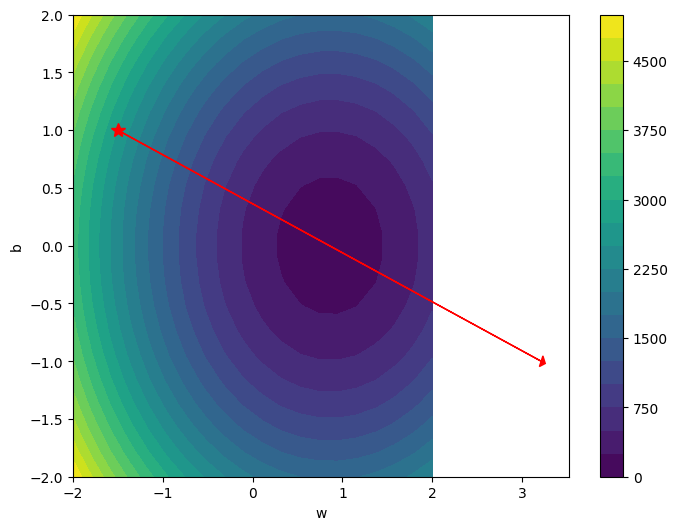

In [19]:
fig, ax = plt.subplots(figsize=(8, 6))

plot_loss_contour(Ws, bs, errs)

plt.plot(W[0][0], b, "r*", markersize=10)
plt.arrow(
    W[0][0],
    b,
    -grad_W[0][0],
    -grad_b,
    head_width=0.1,
    head_length=0.05,
    width=0.0001,
    color="red",
)

In order to not overshoot, we introduce a learning rate $ \alpha $. Here's how we adjust our parameters:

$$
W^{(t+1)} = W^{(t)} - \alpha * \frac{\partial L}{\partial W}
$$

here $t$ indexes a step in the gradient descent process.


In [20]:
lr = 0.1
W, b = np.array([[-1.5]]), np.float64(1)
W = W[0][0]

weight_history = []

Gradient:  [[-4.71158605]] 2.0000000000000004


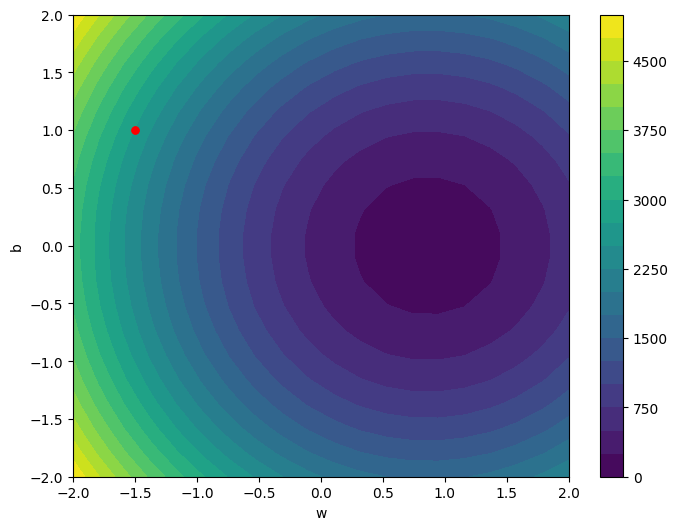

In [21]:
fig, ax = plt.subplots(figsize=(8, 6))
weight_history.append((W, b))

plot_loss_contour(Ws, bs, errs)

ax.plot(W, b, "r.", markersize=10)

grad_W, grad_b = gradient(X, y, W, b)
print("Gradient: ", grad_W, grad_b)
W = W - lr * grad_W
b = b - lr * grad_b

for W_, b_ in weight_history:
    ax.plot(W_, b_, "r.", markersize=10)


In [22]:
for i in range(100):
    W = W - lr * gradient(X, y, W, b)[0]
    b = b - lr * gradient(X, y, W, b)[1]


In [23]:
W, b

(array([[0.86169727]]), np.float64(1.6296303703757927e-10))

In [24]:
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
linreg.fit(X, y)
print(linreg.coef_)
print(linreg.intercept_)


[[0.86169727]]
[1.48249408e-16]


And that is gradient descent! Let's put it all together again.


In [25]:
# Data
X = df[["limit"]].values
y = df[["balance"]].values

# X = df[["limit", "income"]].values

# Initial weights and bias
W, b = generate_random_weights(n_weights=X.shape[1])

# Loss function
def sum_of_squares(z, y):
    return np.sum((z - y)**2)

# Gradient
def gradient(X, y, W, b):
    z = model(X, W, b)
    err = y - z
    grad_W = -2 * np.dot(X.T, err) / len(y)
    grad_b = -2 * np.sum(err) / len(y)
    return grad_W, grad_b


# Gradient descent
lr = 0.01
for i in range(10000):
    grad_W, grad_b = gradient(X, y, W, b)
    W = W - lr * grad_W
    b = b - lr * grad_b

W, b

(array([[ 1.32701455],
        [-0.5874563 ]]),
 np.float64(3.332459158650127e-16))

We used to know the example shown above as simple linear regression. But that is also a neural network in it's most basic form.
 
![](reg_one_feature.png)


If we used more features, the network would look like this:

![](reg_two_features.png)


## Adding layers

We can construct a more complex network as such:

![](reg_two_layers.png)

Now our network has a hidden layer - the layer that receives inputs. 

In [26]:
def model(X, W1, b1, W2, b2):
    z1 = np.dot(X, W1) + b1
    z2 = np.dot(z1, W2) + b2
    return z2



But is this really more complex? After all, we're just applying another linear transformation on top of an existing linear transformation. And even though we can train such a network, it would not fit a more complex function than the simple linear regression from before.

We need to apply a nonlinear transformation in the first hidden layer. One popular choice is the sigmoid function.

![](reg_two_layers_sigmoid.png)


Importantly, the last layer (the output layer) does not use an activation function, because this is a regression model and don't want to squish the output to be between 0 and 1.


In [27]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


In [28]:
def model(X, W1, b1, W2, b2):
    z1 = np.dot(X, W1) + b1
    a1 = sigmoid(z1)
    z2 = np.dot(a1, W2) + b2
    return z2


What is the loss surface of this function? That's difficult to plot since now we have 4 parameters in total. Therefore, we have to fix some of the parameters in place.

In [32]:
W2_fixed = np.array([[1]])
b2_fixed = 0

Ws = np.linspace(-100, 100, 100)
bs = np.linspace(-100, 50, 100)
errs = np.zeros((len(bs), len(Ws)))

for i in range(len(bs)):
    for j in range(len(Ws)):
        W1_val = np.array([[Ws[j]]])
        b1_val = bs[i]
        X_1d = X[:, 0:1]
        z_pred = model(X_1d, W1_val, b1_val, W2_fixed, b2_fixed)
        errs[i, j] = sum_of_squares(z_pred, y)

fig = go.Figure(data=[go.Surface(x=Ws, y=bs, z=errs, colorscale='Viridis')])
fig.update_layout(
    scene=dict(
        xaxis_title='W1',
        yaxis_title='b1',
        zaxis_title='Loss'
    ),
    width=1000,
    height=800
)
fig.show()

How do we train such a network? The problem is that the layers in the network are stacked. The weights in the second layer now respond to changes in the weights (and therefore activations) in the first layer. To find the gradients in such a network, we need backpropagation.

For now, let's pretend that we have the weights of the network. What kind of function is it fitting?


In [52]:
W1 = np.array([[-1.03963907]])
b1 = np.array([0.04051288])
W2 = np.array([[-4.14643086]])
b2 = np.array([2.14470982])


In [53]:
y_pred = model(X, W1, b1, W2, b2)

TypeError: model() takes 3 positional arguments but 5 were given

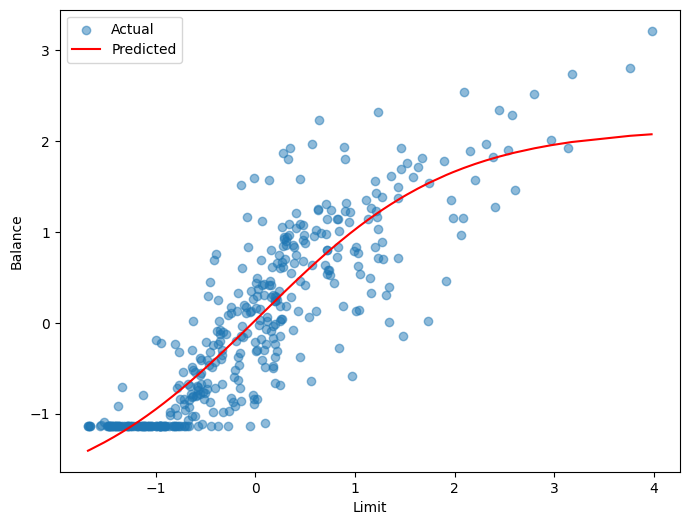

In [54]:
plt.figure(figsize=(8,6))
plt.scatter(df['limit'], y, alpha=0.5, label='Actual')

sort_idx = df['limit'].argsort()
plt.plot(df['limit'][sort_idx], y_pred[sort_idx], 'r-', label='Predicted')

plt.xlabel('Limit')
plt.ylabel('Balance')
plt.legend()
plt.show()
